# Polynomial Regression

* 회귀가 독립변수의 단항식이 아닌 2차, 3차 방정식과 같은 다항식으로 표현되는 것을 다항회귀라고 함.
* 다항 회귀는 선형 회귀 
* 사이킷런은 다항 회귀를 위한 클래스를 제공하지 않음. 따라서 비선형 함수를 선형 모델에 적용시키는 방법을 사용해 구현함.

In [1]:
import numpy as np
# PolynomialFeatures class로 원본 단항 피쳐들을 다항 피쳐들로 변환
from sklearn.preprocessing import PolynomialFeatures
# 단항식 생성
X = np.arange(4).reshape(2,2)
print('일차 단항식 계수 feature:\n', X)

# degree=2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
print('변환된 2차 다항식 계수 feature:\n', X_poly)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 feature:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


단항식에서 [$x_1, x_2$]를

2차 다항식에서 [$1, x_1, x_2, x_1^2, x_1x_2, x_2^2$] 으로 나타내는 것

Example. $y=1+2x_1+3x_1^2+4x_2^3$ 를 3차 다항 회귀식으로 나타내보기

In [8]:
def true_func(x): 
    y = 1 + 2*x[:,0] + 3*x[:,0]**2 + 4*x[:,1]**3
    return y

X = np.arange(4).reshape(2,2)  # 2 features, 2 rows data
y = true_func(X)               # real y 

In [9]:
# 3차 다항으로 , 즉 10개의 feature으로 변환
X_poly_3 = PolynomialFeatures(degree=3).fit_transform(X)
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly_3, y)

print('Polynomial 회귀 계수 \n',np.round(model.coef_, 2))
print('Polynomial 회귀 shape:', model.coef_.shape)


Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 shape: (10,)


이번에는 피쳐 변환과 선형 회귀 적용을 각각 별도로 하지 않고 **사이킷런의 Pipeline 객체**를 이용해 한 번에 다항 회귀 구현해보기

In [13]:
from sklearn.pipeline import Pipeline

In [15]:
# pipeline 객체로 feature 변환과 linear regression을 한 번에 연결
model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])
X = np.arange(4).reshape(2,2)
y = true_func(X)
model = model.fit(X,y)
print('Polynomial 회귀 계수 \n', np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


### Polynomial Regression을 이용한 boston house price prediction

In [17]:
import pandas as pd
boston = pd.read_csv('boston.csv')

In [27]:
X = boston.iloc[:,:-1]
y = boston.iloc[:,-1]

from sklearn.model_selection import train_test_split
X_train,  X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

p_model = Pipeline([('poly', PolynomialFeatures(degree=2, include_bias=False)),
                    ('linear', LinearRegression())])
p_model.fit(X_train, y_train)
y_preds = p_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)
r2_score = r2_score(y_test, y_preds)
print('MSE: {0:.3f} , RMSE: {1:.3f}, R2 Score: {2:.3f}'.format(mse, rmse, r2_score))


MSE: 13.121 , RMSE: 3.622, R2 Score: 0.857


# Underfitting and Overfitting

degree 1 MSE 는 0.4077289625098685
degree 4 MSE 는 0.04320874987232056
degree 15 MSE 는 181238260.14863485


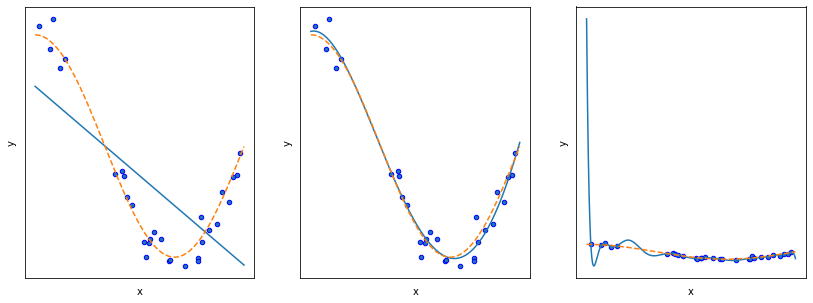

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples)*0.1

plt.figure(figsize=(14,5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks = (), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    lr = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", lr)
        ]
    )
    pipeline.fit(X.reshape(-1,1), y)

    # evaluate model using cross validation
    scores = cross_val_score(
        pipeline, X.reshape(-1,1),y, scoring = "neg_mean_squared_error", cv=10
    )
    print('degree {0} MSE 는 {1}'.format(degrees[i], -1 * np.mean(scores)))

    # compare the polynomial regression with true function
    x_test =  np.arange(0.00,1.0,0.001).reshape(-1,1)
    y_true = true_fun(x_test)

    # predicted curve w.t poly~
    plt.plot(x_test, pipeline.predict(x_test), label = 'Model')
    plt.plot(x_test, y_true, '--', label = 'True function')
    plt.scatter(X, y, edgecolor='b',s=20,label='Samples')
    plt.xlabel('x')
    plt.ylabel('y')

plt.show()



degree 15 일 때 MSE가 엄청 크게 나왔다는 것을 알 수 있음

In [31]:
polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
lr = LinearRegression()
pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", lr)
        ]
    )
pipeline.fit(X.reshape(-1,1), y)

pipeline.named_steps['linear_regression'].coef_

array([-2.98291444e+03,  1.03898885e+05, -1.87415324e+06,  2.03715471e+07,
       -1.44872830e+08,  7.09313489e+08, -2.47065245e+09,  6.24559902e+09,
       -1.15676336e+10,  1.56894743e+10, -1.54005873e+10,  1.06457184e+10,
       -4.91377255e+09,  1.35919593e+09, -1.70380747e+08])

차수 15일때 회귀 계수부터 말도 안되게 크게 나오니, 조금만 달라도 error가 엄청 커짐을 확인할 수 있음

순서대로 under-fitted / well-fitted / over-fitted 라는 것을 알 수 있음

# Bias-Variance Trade Off